## Post-Processed Stitching
This notebook stitches measurements AFTER reconstruction is performed for each segment.

In [1]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

# Load motiondeblur module and Dataset class
import libwallerlab.projects.motiondeblur as md
from libwallerlab.utilities.io import Dataset, isDataset
from matplotlib_scalebar.scalebar import ScaleBar

# Platform imports
import os, glob
from os.path import expanduser
import numpy as np

# Debugging imports
import llops as yp
import matplotlib.pyplot as plt

yp.config.setDefaultBackend('numpy')
yp.config.setDefaultDatatype('float32')

## Load Data

In [5]:
# Define user for path setting
dataset_path = expanduser("~") + '/datasets/motiondeblur/output/'

# Define output directory
output_path = os.path.join(dataset_path, 'paper/')

# Define which dataset to use
dataset_type = 'raw'
dataset_label = 'strobe'

# Find files in this directory
saved_output_files = glob.glob(os.path.join(dataset_path, '*' + dataset_type + '*.npz'))
filtered_output_files = sorted([file for file in saved_output_files if dataset_label in file])
print('Found %d files.'% len(filtered_output_files))

segment_data, roi_list, measurement_list, recon_list, segment_index_list = [], [], [], [], []
for output_file in filtered_output_files:
    segment_data = np.load(output_file)
    roi_list.append(yp.Roi(**segment_data['roi'].item()))
    measurement_list.append(yp.cast(segment_data['y']))
    recon_list.append(yp.cast(segment_data['object_recovered']))
    segment_index_list.append(segment_data['segment_index'])

# Move all ROI objects to origin   
md.recon.alignRoiListToOrigin(roi_list)

Found 7 files.


## Perform Stitching

<IPython.core.display.Javascript object>


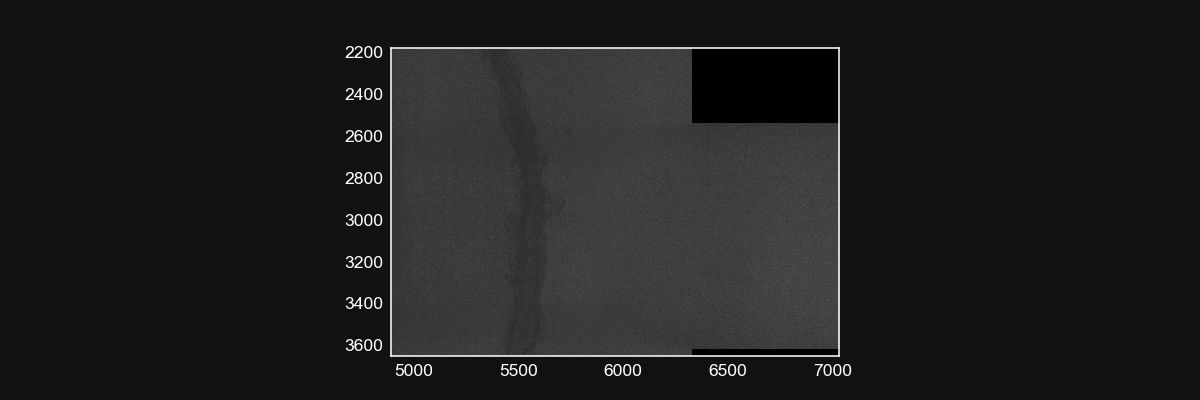

In [7]:
import ndoperators as ops

# Generate segmenetation Operator
G = ops.Segmentation(roi_list, alpha_blend_size=1000)

# Concatenate measurements
y = ops.VecStack(recon_list)

# Perform reconstruction
stitched = G.inv * y

plt.figure(figsize=(8,8))
plt.imshow(stitched)

In [25]:
# scale_list, _ = md.recon.normalize_roi_list(recon_list, roi_list)
# recon_list_norm = yp.dcopy(recon_list)
# recon_list_norm = [meas * scale for (meas, scale) in zip(recon_list_norm, scale_list)]

<IPython.core.display.Javascript object>


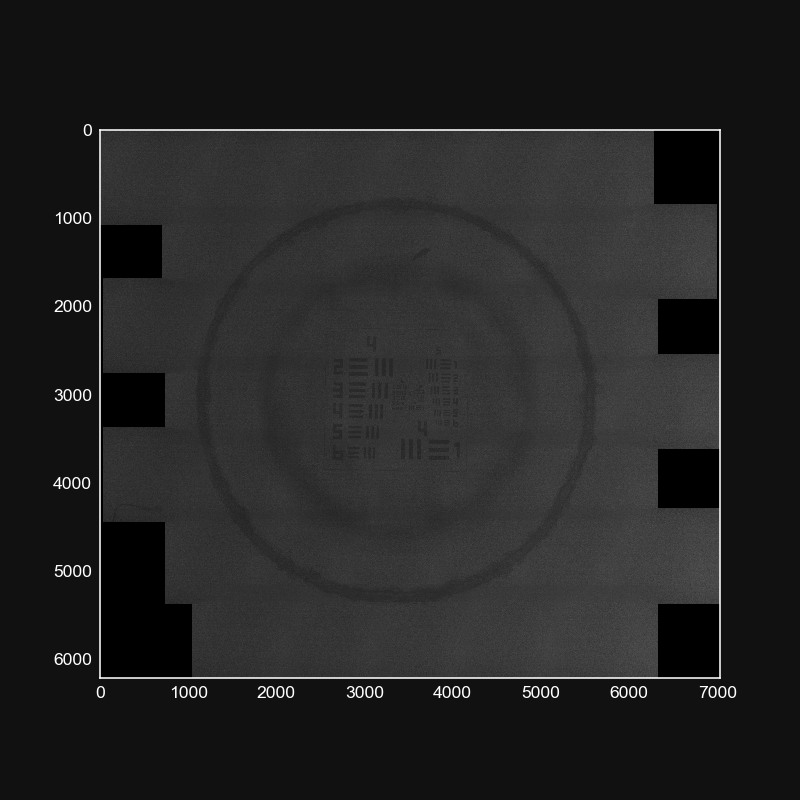

In [26]:
import ndoperators as ops

# Generate segmenetation Operator
G = ops.Segmentation(roi_list, alpha_blend_size=1000)

# Concatenate measurements
y = ops.VecStack(recon_list_norm)

# Perform reconstruction
stitched = G.inv * y

plt.figure(figsize=(8,8))
plt.imshow(stitched)

In [8]:
np.savez('/Users/zfphil/datasets/strobe_stitched.npz', x=stitched)

## Generate Figure With Scale Bar

In [210]:
m = yp.mean(stitched)
stitched -= m
stitched /= m

<IPython.core.display.Javascript object>


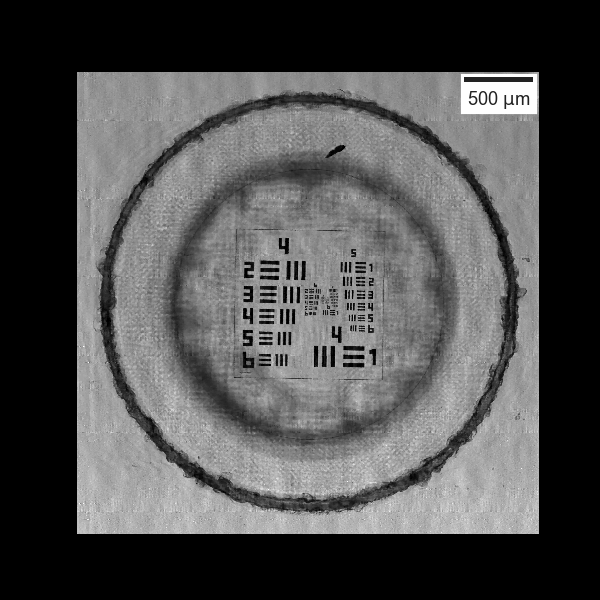

<IPython.core.display.Javascript object>


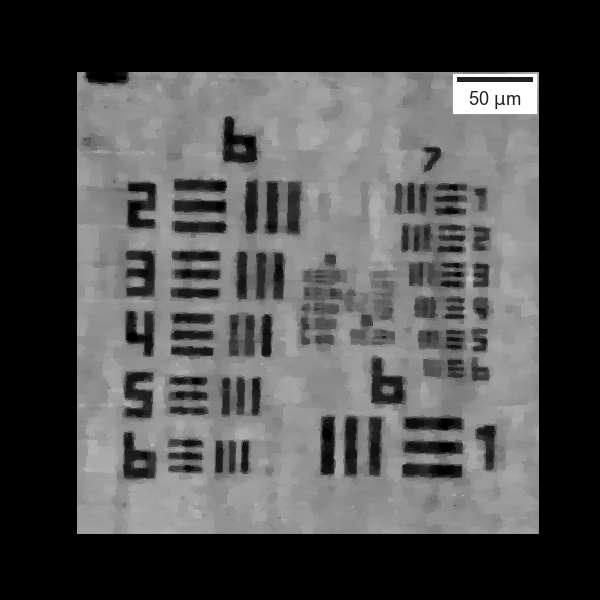

In [211]:
from matplotlib_scalebar.scalebar import ScaleBar

label = 'coded_refined'
# Crop ROI
crop_roi = yp.Roi(start=(550,1200),shape=(5000,5000))

with plt.style.context('dark_background'):
    plt.figure(figsize=(6,6))
    plt.imshow(stitched[crop_roi.slice])
    clim = plt.gci().get_clim()
    scalebar = ScaleBar(0.67, 'um') # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')
    plt.clim((-1,1))
    
    plt.savefig(os.path.join(output_path, 'figure_' + label +'.png'), transparent=True, dpi=300)
    
# Crop ROI
zoom_roi = yp.Roi(start=(2790,3620),shape=(450,450))

with plt.style.context('dark_background'):
    plt.figure(figsize=(6,6))
    plt.imshow(stitched[zoom_roi.slice])
    plt.clim((-1,1))
    scalebar = ScaleBar(0.67, 'um') # 1 pixel = 0.2 meter
    plt.gca().add_artist(scalebar)
    plt.axis('off')
    
    plt.savefig(os.path.join(output_path, 'figure_' + label + '_zoom.png'), transparent=True, dpi=300)
    
# Save numpy
np.savez(os.path.join(output_path, 'figure_' + label + '_output.npz'), stitched=stitched, zoom_roi=zoom_roi.__dict__(), label=label, crop_roi=crop_roi.__dict__())

In [197]:
# import skimage
# denoised = skimage.restoration.denoise_tv_bregman(stitched.astype(np.double), 1e-4)
# plt.figure()
# plt.imshow(denoised)

In [ ]:
# label = 'strobe_tv'
# save = False
# # Crop ROI
# crop_roi = yp.Roi(start=(570,870),shape=(5000,5000))

# with plt.style.context('dark_background'):
#     plt.figure(figsize=(6,6))
#     plt.imshow(stitched[crop_roi.slice])
#     clim = plt.gci().get_clim()
#     scalebar = ScaleBar(0.67, 'um') # 1 pixel = 0.2 meter
#     plt.gca().add_artist(scalebar)
#     plt.axis('off')
#     plt.clim((-1,1))
    
#     if save:
#         plt.savefig(os.path.join(output_path, 'figure_' + label +'.png'), transparent=True, dpi=300)
    
# # Crop ROI
# zoom_roi = yp.Roi(start=(2785,3270),shape=(450,450))

# with plt.style.context('dark_background'):
#     plt.figure(figsize=(6,6))
#     plt.imshow(stitched[zoom_roi.slice])
#     plt.clim((-1,1))
#     scalebar = ScaleBar(0.67, 'um') # 1 pixel = 0.2 meter
#     plt.gca().add_artist(scalebar)
#     plt.axis('off')
    
#     if save:
#         plt.savefig(os.path.join(output_path, 'figure_' + label + '_zoom.png'), transparent=True, dpi=300)
    
# # Save numpy
# if save:
#     np.savez(os.path.join(output_path, 'figure_' + label + '_output.npz'), stitched=stitched, zoom_roi=zoom_roi.__dict__, label=label, crop_roi=crop_roi.__dict__)

## Save Reconstruction

In [ ]:
output_path

In [ ]:
import tifffile
stitched_8 = stitched.copy()
stitched_8 -= np.min(stitched_8)
stitched_8 /= 0.99 *np.max(stitched_8)
stitched_8 *= 255
stitched_8 = stitched_8.astype(np.uint8)

tifffile.imsave(os.path.join(output_path + '/stitched_STATIC.tiff'), stitched_8)

In [ ]:
np.savez(os.path.join(output_path + '/stitched_STATIC.npz'), stitched=stitched_8)